### Engenharia do Conhecimento 2022/2023 - Projeto 2 - Grupo 12 - Ana Teixeira | Francisco Abreu | João Matos | Tomás Piteira

### 1. Introdução e Objetivos

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
pd.set_option('display.max_columns', None)
dataset = pd.read_csv('biodegradable_a.csv')

### 2. Processamento de Dados

#### 2.1 Variáveis Categóricas em Contínuas

In [2]:
# Uncomment to see the graphic

# import matplotlib.pyplot as plt
# # Set the size of each subplot
# fig, axs = plt.subplots(14, 3, figsize=(20, 40))
# fig.tight_layout(pad=3.0)
# # Flatten the axs array to make it easier to iterate over the subplots
# axs = axs.flatten()
# # Iterate over each column and plot the data in the corresponding subplot
# for i, col in enumerate(dataset.columns):
#     axs[i].scatter(dataset.index, dataset[col])
#     axs[i].set_title(col)
#     axs[i].set_xlabel('Index')
#     axs[i].set_ylabel(col)
# plt.show()

In [3]:
import pandas as pd
#filtered_columns = ['B01', 'B03', 'B04', 'Biodegradable']
filtered_columns = ['Biodegradable']
categorical = [col for col in dataset.columns if (col in filtered_columns)]
dataset = pd.get_dummies(dataset, columns=categorical, drop_first=True)
for col in [c for c in categorical if c != 'Biodegradable']:
    if f'{col}_1.0' in dataset.columns:
        dataset.rename(columns={f'{col}_1.0': col}, inplace=True)
    else:
        unique_values = dataset[col].unique()
        for value in unique_values:
            if pd.notna(value):
                column_name = f'{col}_{value}'
                if column_name in dataset.columns:
                    dataset.rename(columns={column_name: col}, inplace=True)

#### 2.2. Separar Conjunto de Treino e Teste

In [4]:
from sklearn.model_selection import train_test_split
X = dataset.drop(columns=["Biodegradable_RB"])
y = dataset["Biodegradable_RB"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)

#### 2.3. Cross-validation *(DecisionTreeClassifier & LogisticRegression)*

In [5]:
#1. Use the Training Set for n-Fold Cross Validation
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
def cross_validation_decision_tree(X_train, y_train):
    kf = KFold(n_splits=5, shuffle=True)
    TRUTH=None
    PREDS=None
    for train_index, test_index in kf.split(X_train):
        X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
        y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
        mdl = DecisionTreeClassifier(max_depth=5)
        mdl.fit(X_train_cv, y_train_cv)
        preds = mdl.predict(X_test_cv)
        if TRUTH is None:
            PREDS=preds
            TRUTH=y_test_cv
        else:
            PREDS=np.hstack((PREDS, preds))
            TRUTH=np.hstack((TRUTH, y_test_cv))
    return TRUTH, PREDS
def cross_validation_logistic_regression(X_train, y_train):
    kf = KFold(n_splits=5, shuffle=True)
    TRUTH=None
    PREDS=None
    for train_index, test_index in kf.split(X_train):
        X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
        y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
        mdl = LogisticRegression(max_iter=1000)
        mdl.fit(X_train_cv, y_train_cv)
        preds = mdl.predict(X_test_cv)
        if TRUTH is None:
            PREDS=preds
            TRUTH=y_test_cv
        else:
            PREDS=np.hstack((PREDS, preds))
            TRUTH=np.hstack((TRUTH, y_test_cv))
    return TRUTH, PREDS

In [6]:
#2. evaluate the resulting model with the known statistics
from sklearn.metrics import f1_score, matthews_corrcoef, precision_score, recall_score
def print_cross_validation_stats(TRUTH, PREDS): 
    print("These are the training set statistics:")
    print("The Precision is: %7.4f" % precision_score(TRUTH, PREDS))
    print("The Recall is: %7.4f" % recall_score(TRUTH, PREDS))
    print("The F1 score is: %7.4f" % f1_score(TRUTH, PREDS))
    print("The Matthews correlation coefficient is: %7.4f" % matthews_corrcoef(TRUTH, PREDS))

#### 2.4. Valores em falta *(NaN>14.5%)*

In [7]:
import pandas as pd
threshold = len(X_train) * 0.145
X_train_cleaned = X_train.dropna(axis=1, thresh=(len(X_train) - threshold))
dropped_columns = X_train.columns.difference(X_train_cleaned.columns)
print("Columns dropped:", ', '.join(dropped_columns))

Columns dropped: C, SpMax_A, SpMax_B


#### 2.5. Imputer
+ Usámos estratégias diferentes dependendo do tipo de dados
+ Coluna *Biodegradable* não tem valores em falta como era esperado

##### 2.5.1. SimpleImputer

In [8]:
imputer_mean = SimpleImputer(strategy='mean')
imputer_mode = SimpleImputer(strategy='most_frequent')
# Define the columns that will be imputed with the most frequent value
most_frequent = ['nHM', 'NssssC', 'nCb', 'nO', 'nN_N', 'nArNO2', 'nCRX3', 'nCIR', 'N_073', 'nCrt', 'nHDon', 'nN', 'nArCOOR', 'B01', 'B03', 'B04']
X_train_mode = X_train[most_frequent]
X_train_mean = X_train.drop(columns=most_frequent)
X_train_mode_imputed = pd.DataFrame(imputer_mode.fit_transform(X_train_mode), columns=X_train_mode.columns)
X_train_mean_imputed = pd.DataFrame(imputer_mean.fit_transform(X_train_mean), columns=X_train_mean.columns)
X_train_imputed = pd.concat([X_train_mean_imputed, X_train_mode_imputed], axis=1)
# Evaluate the Imputer strategy using Cross-validation (Decision Tree and Logistic Regression)
print("SIMPLE IMPUTER - Sem retirar NaN")
print()
TRUTH, PREDS = cross_validation_decision_tree(X_train_imputed.values, y_train.values)
print("USING DECISION TREE: ")
print_cross_validation_stats(TRUTH, PREDS)
print()
print("USING LOGISTIC REGRESSION: ")
TRUTH, PREDS = cross_validation_logistic_regression(X_train_imputed.values, y_train.values)
print_cross_validation_stats(TRUTH, PREDS)

SIMPLE IMPUTER - Sem retirar NaN

USING DECISION TREE: 
These are the training set statistics:
The Precision is:  0.9511
The Recall is:  0.9884
The F1 score is:  0.9694
The Matthews correlation coefficient is:  0.7886

USING LOGISTIC REGRESSION: 
These are the training set statistics:
The Precision is:  0.9546
The Recall is:  0.9853
The F1 score is:  0.9697
The Matthews correlation coefficient is:  0.7923


In [9]:
imputer_mean = SimpleImputer(strategy='mean')
imputer_mode = SimpleImputer(strategy='most_frequent')
most_frequent = ['nHM', 'NssssC', 'nCb', 'nO', 'nN_N', 'nArNO2', 'nCRX3', 'nCIR', 'N_073', 'nCrt', 'nHDon', 'nN', 'nArCOOR', 'B01', 'B03', 'B04']
# Split the training dataset into two parts: columns in 'most_frequent' and the rest
X_train_cleaned_mode = X_train_cleaned[most_frequent]
X_train_cleaned_mean = X_train_cleaned.drop(columns=most_frequent)
# Impute missing values in the training dataset
X_train_cleaned_mode_imputed = pd.DataFrame(imputer_mode.fit_transform(X_train_cleaned_mode), columns=X_train_cleaned_mode.columns)
X_train_mean_cleaned_imputed = pd.DataFrame(imputer_mean.fit_transform(X_train_cleaned_mean), columns=X_train_cleaned_mean.columns)
# Combine the imputed datasets
X_train_cleaned_imputed = pd.concat([X_train_mean_cleaned_imputed, X_train_cleaned_mode_imputed], axis=1)
print("SIMPLE IMPUTER - a retirar NaN")
print()
TRUTH, PREDS = cross_validation_decision_tree(X_train_cleaned_imputed.values, y_train.values)
print("USING DECISION TREE: ")
print_cross_validation_stats(TRUTH, PREDS)
print()
print("USING LOGISTIC REGRESSION: ")
TRUTH, PREDS = cross_validation_logistic_regression(X_train_cleaned_imputed.values, y_train.values)
print_cross_validation_stats(TRUTH, PREDS)

SIMPLE IMPUTER - a retirar NaN

USING DECISION TREE: 
These are the training set statistics:
The Precision is:  0.9552
The Recall is:  0.9845
The F1 score is:  0.9697
The Matthews correlation coefficient is:  0.7926

USING LOGISTIC REGRESSION: 
These are the training set statistics:
The Precision is:  0.9560
The Recall is:  0.9857
The F1 score is:  0.9706
The Matthews correlation coefficient is:  0.7993


##### 2.5.2. KNNImputer

In [10]:
from sklearn.impute import KNNImputer
imputer_knn = KNNImputer(n_neighbors=5)
# Impute missing values in the training dataset
X_train_knn_imputed = imputer_knn.fit_transform(X_train)
# Convert back to DataFrame (if necessary for your downstream tasks)
X_train_knn_imputed = pd.DataFrame(X_train_knn_imputed, columns=X_train.columns)
print("KNN IMPUTER - Sem retirar NaN")
print()
TRUTH, PREDS = cross_validation_decision_tree(X_train_knn_imputed.values, y_train.values)
print("USING DECISION TREE: ")
print_cross_validation_stats(TRUTH, PREDS)
print()
print("USING LOGISTIC REGRESSION: ")
TRUTH, PREDS = cross_validation_logistic_regression(X_train_knn_imputed.values, y_train.values)
print_cross_validation_stats(TRUTH, PREDS)

KNN IMPUTER - Sem retirar NaN

USING DECISION TREE: 
These are the training set statistics:
The Precision is:  0.9484
The Recall is:  0.9841
The F1 score is:  0.9660
The Matthews correlation coefficient is:  0.7642

USING LOGISTIC REGRESSION: 
These are the training set statistics:
The Precision is:  0.9563
The Recall is:  0.9849
The F1 score is:  0.9704
The Matthews correlation coefficient is:  0.7981


In [11]:
from sklearn.impute import KNNImputer
imputer_knn = KNNImputer(n_neighbors=5)
X_train_knn_cleaned_imputed = imputer_knn.fit_transform(X_train_cleaned)
# Convert back to DataFrame (if necessary for your downstream tasks)
X_train_knn_cleaned_imputed = pd.DataFrame(X_train_knn_cleaned_imputed, columns=X_train_cleaned.columns)
print("KNN IMPUTER - a retirar NaN")
print()
TRUTH, PREDS = cross_validation_decision_tree(X_train_knn_cleaned_imputed.values, y_train.values)
print("USING DECISION TREE: ")
print_cross_validation_stats(TRUTH, PREDS)
print()
print("USING LOGISTIC REGRESSION: ")
TRUTH, PREDS = cross_validation_logistic_regression(X_train_knn_cleaned_imputed.values, y_train.values)
print_cross_validation_stats(TRUTH, PREDS)

KNN IMPUTER - a retirar NaN

USING DECISION TREE: 
These are the training set statistics:
The Precision is:  0.9527
The Recall is:  0.9833
The F1 score is:  0.9678
The Matthews correlation coefficient is:  0.7789

USING LOGISTIC REGRESSION: 
These are the training set statistics:
The Precision is:  0.9553
The Recall is:  0.9849
The F1 score is:  0.9698
The Matthews correlation coefficient is:  0.7939


In [12]:
X_test_knn_cleaned_imputed = imputer_knn.fit_transform(X_test)
X_test_knn_cleaned_imputed = pd.DataFrame(X_test_knn_cleaned_imputed, columns=X_test.columns)

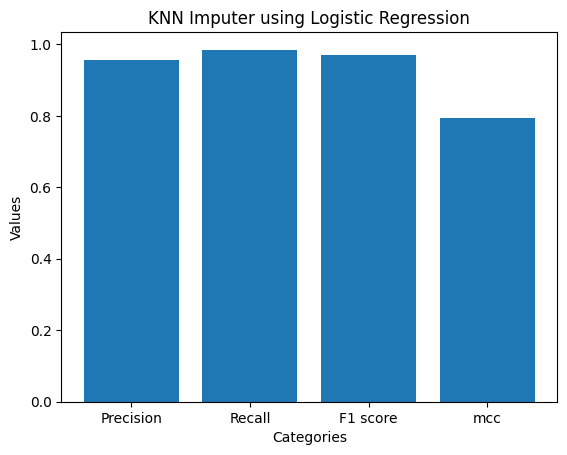

In [13]:
#Show the graphic from metrics of knn imputer using logistic regression
import matplotlib.pyplot as plt

categories = ['Precision', 'Recall', 'F1 score', 'mcc']
values = [precision_score(TRUTH, PREDS), recall_score(TRUTH, PREDS), f1_score(TRUTH, PREDS), matthews_corrcoef(TRUTH, PREDS)]
plt.bar(categories, values)
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('KNN Imputer using Logistic Regression')

plt.show()

#### 2.6. Scaler

##### 2.6.1 MinMax Scaler

In [14]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
scaler = MinMaxScaler()
nonScalerColumns = ['nHM', 'NssssC', 'nCb', 'nCp', 'nO', 'nN_N', 'nArNO2', 'nCRX3', 'nCIR', 'N_073', 'nCrt', 'nHDon', 'nN', 'nArCOOR', 'nX', 'B01', 'B03', 'B04']
integer_data = X_train_knn_cleaned_imputed[nonScalerColumns]
# Drop the integer columns from the dataset
X_train_minmax_scaled = X_train_knn_cleaned_imputed.drop(columns=nonScalerColumns)
# Perform scaling
X_train_minmax_scaled = pd.DataFrame(scaler.fit_transform(X_train_minmax_scaled), columns=X_train_minmax_scaled.columns)
# Append the integer columns back to the dataset
X_train_minmax_scaled[nonScalerColumns] = integer_data
print("MINMAX SCALER")
print()
TRUTH, PREDS = cross_validation_decision_tree(X_train_minmax_scaled.values, y_train.values)
print("USING DECISION TREE: ")
print_cross_validation_stats(TRUTH, PREDS)
print()
print("USING LOGISTIC REGRESSION: ")
TRUTH, PREDS = cross_validation_logistic_regression(X_train_minmax_scaled.values, y_train.values)
print_cross_validation_stats(TRUTH, PREDS)

MINMAX SCALER

USING DECISION TREE: 
These are the training set statistics:
The Precision is:  0.9544
The Recall is:  0.9806
The F1 score is:  0.9673
The Matthews correlation coefficient is:  0.7773

USING LOGISTIC REGRESSION: 
These are the training set statistics:
The Precision is:  0.9507
The Recall is:  0.9868
The F1 score is:  0.9684
The Matthews correlation coefficient is:  0.7819


##### 2.6.2 Standard Scaler

In [15]:
scaler = StandardScaler()
nonScalerColumns = ['nHM', 'NssssC', 'nCb', 'nCp', 'nO', 'nN_N', 'nArNO2', 'nCRX3', 'nCIR', 'N_073', 'nCrt', 'nHDon', 'nN', 'nArCOOR', 'nX', 'B01', 'B03', 'B04']
integer_data = X_train_knn_cleaned_imputed[nonScalerColumns]
# Drop the integer columns from the dataset
X_train_standard_scaled = X_train_knn_cleaned_imputed.drop(columns=nonScalerColumns)
# Perform scaling
X_train_standard_scaled = pd.DataFrame(scaler.fit_transform(X_train_standard_scaled), columns=X_train_standard_scaled.columns)
# Append the integer columns back to the dataset
X_train_standard_scaled[nonScalerColumns] = integer_data
print("STANDARD SCALER")
print()
TRUTH, PREDS = cross_validation_decision_tree(X_train_standard_scaled.values, y_train.values)
print("USING DECISION TREE: ")
print_cross_validation_stats(TRUTH, PREDS)
print()
print("USING LOGISTIC REGRESSION: ")
TRUTH, PREDS = cross_validation_logistic_regression(X_train_standard_scaled.values, y_train.values)
print_cross_validation_stats(TRUTH, PREDS)

STANDARD SCALER

USING DECISION TREE: 
These are the training set statistics:
The Precision is:  0.9495
The Recall is:  0.9829
The F1 score is:  0.9659
The Matthews correlation coefficient is:  0.7647

USING LOGISTIC REGRESSION: 
These are the training set statistics:
The Precision is:  0.9561
The Recall is:  0.9872
The F1 score is:  0.9714
The Matthews correlation coefficient is:  0.8044


In [16]:
integer_data_test = X_test_knn_cleaned_imputed[nonScalerColumns]
X_test_standard_scaled = X_test_knn_cleaned_imputed.drop(columns=nonScalerColumns)
X_test_standard_scaled = pd.DataFrame(scaler.fit_transform(X_test_standard_scaled), columns=X_test_standard_scaled.columns)
X_test_standard_scaled[nonScalerColumns] = integer_data_test
X_test = X_test_standard_scaled

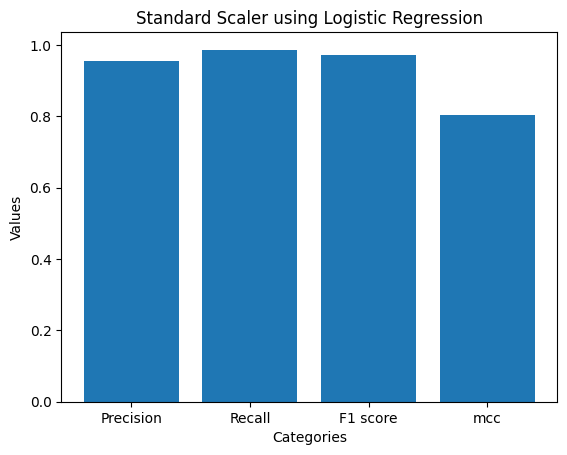

In [17]:
#Show the graphic from metrics of standard scaler using logistic regression
categories = ['Precision', 'Recall', 'F1 score', 'mcc']
values = [precision_score(TRUTH, PREDS), recall_score(TRUTH, PREDS), f1_score(TRUTH, PREDS), matthews_corrcoef(TRUTH, PREDS)]
plt.bar(categories, values)
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Standard Scaler using Logistic Regression')
plt.show()

### 3. Seleção de Variáveis

#### 3.1. Pela Variância

In [18]:
feature_variances = np.var(X_train_standard_scaled, axis=0)
threshold = 0.01
low_variance_columns = [i for i, var in enumerate(feature_variances) if var < threshold]
low_variance_columns = [X_train_standard_scaled.columns[i] for i in low_variance_columns]
# Drop the columns with low variance for X_train
X_train_removed_low_variance = X_train_standard_scaled.drop(columns=low_variance_columns)
# Print the columns that were dropped
print("Columns dropped:", ', '.join([f"Feature {i}" for i in low_variance_columns]))
print("Number of columns in X_train:", X_train_removed_low_variance.shape[1])
print("VARIANCE")
print()
TRUTH, PREDS = cross_validation_decision_tree(X_train_removed_low_variance.values, y_train.values)
print("USING DECISION TREE: ")
print_cross_validation_stats(TRUTH, PREDS)
print()
print("USING LOGISTIC REGRESSION: ")
TRUTH, PREDS = cross_validation_logistic_regression(X_train_removed_low_variance.values, y_train.values)
print_cross_validation_stats(TRUTH, PREDS)

Columns dropped: Feature nN_N, Feature B01, Feature B04
Number of columns in X_train: 35
VARIANCE

USING DECISION TREE: 
These are the training set statistics:
The Precision is:  0.9513
The Recall is:  0.9849
The F1 score is:  0.9678
The Matthews correlation coefficient is:  0.7783

USING LOGISTIC REGRESSION: 
These are the training set statistics:
The Precision is:  0.9568
The Recall is:  0.9864
The F1 score is:  0.9714
The Matthews correlation coefficient is:  0.8046


#### 3.2. Stepwise & Correlation

In [19]:
from sklearn.feature_selection import SequentialFeatureSelector
selector = SequentialFeatureSelector(LogisticRegression(), direction='backward', n_features_to_select=3)
selector.fit(X_train_removed_low_variance, y_train)
selected_features = selector.get_support()
selected_features = X_train_removed_low_variance.columns[selected_features].tolist()
# Remove the selected features from X_train_removed_low_variance
X_stepwise = X_train_removed_low_variance.drop(columns=selected_features)
print("STEPWISE")
TRUTH, PREDS = cross_validation_decision_tree(X_stepwise.values, y_train.values)
print("USING DECISION TREE: ")
print_cross_validation_stats(TRUTH, PREDS)
print()
print("USING LOGISTIC REGRESSION: ")
TRUTH, PREDS = cross_validation_logistic_regression(X_stepwise.values, y_train.values)
print_cross_validation_stats(TRUTH, PREDS)

STEPWISE
USING DECISION TREE: 
These are the training set statistics:
The Precision is:  0.9374
The Recall is:  0.9860
The F1 score is:  0.9611
The Matthews correlation coefficient is:  0.7240

USING LOGISTIC REGRESSION: 
These are the training set statistics:
The Precision is:  0.9503
The Recall is:  0.9853
The F1 score is:  0.9675
The Matthews correlation coefficient is:  0.7753


In [20]:
from scipy.stats import pearsonr
correlations = X_train_removed_low_variance.apply(lambda x: np.abs(np.corrcoef(x, y_train, rowvar=False)[0, 1]))
selected_features = correlations.nlargest(30).index.tolist()
X_correlation = X_train_removed_low_variance[selected_features]
print("CORRELATION")
TRUTH, PREDS = cross_validation_decision_tree(X_correlation.values, y_train.values)
print("USING DECISION TREE: ")
print_cross_validation_stats(TRUTH, PREDS)
print()
print("USING LOGISTIC REGRESSION: ")
TRUTH, PREDS = cross_validation_logistic_regression(X_correlation.values, y_train.values)
print_cross_validation_stats(TRUTH, PREDS)

CORRELATION
USING DECISION TREE: 
These are the training set statistics:
The Precision is:  0.9566
The Recall is:  0.9818
The F1 score is:  0.9690
The Matthews correlation coefficient is:  0.7896

USING LOGISTIC REGRESSION: 
These are the training set statistics:
The Precision is:  0.9568
The Recall is:  0.9876
The F1 score is:  0.9720
The Matthews correlation coefficient is:  0.8085


In [21]:
# Get a list of columns in each DataFrame
cols_corr = X_correlation.columns
cols_test = X_test.columns
# Identify the missing columns
missing_cols = [col for col in cols_test if col not in cols_corr]
# Drop the missing columns from X_test
X_test = X_test.drop(columns=missing_cols)
X_test = X_test.reindex(columns = X_correlation.columns)

### 4. Resultados dos Modelos
+ 5 modelos - DecisionTreeClassifier, LogisticRegression, SVM, KNN, RandomForestClassifier

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
trained_models = []
results = {}
models = [
    DecisionTreeClassifier(),
    LogisticRegression(),    
    SVC(gamma='auto'),
    KNeighborsClassifier(n_neighbors=5, weights="distance"),
    RandomForestClassifier(n_estimators=100)
]
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    mmc = matthews_corrcoef(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return accuracy, precision, mmc, recall, f1, report, cm

In [23]:
# DecisionTree
dtr= DecisionTreeClassifier(max_depth=5)
dtr.fit(X_correlation, y_train)
trained_models.append(dtr)
# LogisticRegression
lmr=LogisticRegression()
lmr.fit(X_correlation, y_train)
trained_models.append(lmr)
# SVC
svc = SVC(gamma='auto').fit(X_correlation, y_train)
trained_models.append(svc)
# KNN
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
knn.fit(X_correlation, y_train)
trained_models.append(knn)
# RandomForest
rfr= RandomForestClassifier(n_estimators=100)
rfr.fit(X_correlation, y_train)
trained_models.append(rfr)

#### 4.6. Conclusão Melhor Modelo

In [24]:
for trained_model in trained_models:
    accuracy, precision, mcc, recall, f1, report, cm = evaluate_model(trained_model, X_test, y_test)
    results[trained_model.__class__.__name__] = {'Accuracy': accuracy, 'Precision': precision, 'MCC': mcc, 'Recall': recall, 'F1': f1, 'Report': report, 'Confusion Matrix': cm}

In [25]:
average_metrics = {}
# Calculate the average of all metrics for each model
for model_name, metrics in results.items():
    average_metrics[model_name] = (metrics['Accuracy'] + metrics['Precision'] + metrics['Recall'] + metrics['F1']) / 4
# Sort the average_metrics dictionary in descending order and select the top two models
top_two_models = sorted(average_metrics, key=average_metrics.get, reverse=True)[:2]
print(f"{'Model':<25} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10}")
print("-" * 60)
for model_name in top_two_models:
    metrics = results[model_name]
    print(f"{model_name:<25} {metrics['Accuracy']:<10.4f} {metrics['Precision']:<10.4f} {metrics['Recall']:<10.4f} {metrics['F1']:<10.4f}")
    print("\nClassification Report:")
    print(metrics['Report'])
    print("\nConfusion Matrix:")
    print(metrics['Confusion Matrix'])
    print("\n" + "-" * 60)
print(f"The top two models are {top_two_models[0]} and {top_two_models[1]}.")

Model                     Accuracy   Precision  Recall     F1        
------------------------------------------------------------
RandomForestClassifier    0.9688     0.9685     0.9688     0.9682    

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       262
           1       0.97      0.99      0.98      1245

    accuracy                           0.97      1507
   macro avg       0.96      0.93      0.94      1507
weighted avg       0.97      0.97      0.97      1507


Confusion Matrix:
[[ 227   35]
 [  12 1233]]

------------------------------------------------------------
SVC                       0.9648     0.9646     0.9648     0.9639    

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.84      0.89       262
           1       0.97      0.99      0.98      1245

    accuracy                           0.96      1507
   macro avg       0.96     

In [26]:
#Uncomment to see the graphic

# import matplotlib.pyplot as plt
# sorted_metrics = sorted(average_metrics.items(), key=lambda x: x[1], reverse=True)
# model_names = [model[0] for model in sorted_metrics]
# model_averages = [model[1] for model in sorted_metrics]
# plt.figure(figsize=(10, 6))
# plt.bar(model_names, model_averages)
# plt.xlabel('Models')
# plt.ylabel('Average Metric')
# plt.title('Average Metrics for Different Models')
# for i, v in enumerate(model_averages):
#     plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

The top two models are <b>RandomForestClassifier</b> and <b>SVC</b>.

### 5. Hyperparamethers Tuning
+ *<b>Top 2</b>* Modelos
+ GridSearchCV
+ Métricas usadas: B30, SS, MEDIAN

#### 5.1. SVC

In [27]:
from sklearn.model_selection import GridSearchCV
param_grid_svc = {
    'gamma': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
    'C': [1, 10, 100, 1e3, 1e4, 1e5]
}
grid_search_svc = GridSearchCV(estimator=SVC(), param_grid=param_grid_svc, scoring={'accuracy': 'balanced_accuracy', 'f1': 'f1', 'precision': 'precision'}, refit=False)
grid_search_svc.fit(X_correlation, y_train)
average_scores_svc = (grid_search_svc.cv_results_['mean_test_accuracy'] + grid_search_svc.cv_results_['mean_test_f1'] + grid_search_svc.cv_results_['mean_test_precision']) / 3
best_index_svc = average_scores_svc.argmax()
print("SUPPORT VECTOR CLASSIFIER")
print('Best hyperparameters:', grid_search_svc.cv_results_['params'][best_index_svc])
print('accuracy score:', grid_search_svc.cv_results_['mean_test_accuracy'][best_index_svc])
print('f1 score:', grid_search_svc.cv_results_['mean_test_f1'][best_index_svc])
print('precision score:', grid_search_svc.cv_results_['mean_test_precision'][best_index_svc])

SUPPORT VECTOR CLASSIFIER
Best hyperparameters: {'C': 10, 'gamma': 0.1}
accuracy score: 0.9316080171358629
f1 score: 0.9803043313689844
precision score: 0.9781077995931102


#### 5.2. RandomForestClassifier

In [28]:
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'criterion': ['gini', 'entropy']
}
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, scoring={'accuracy': 'balanced_accuracy', 'f1': 'f1', 'precision': 'precision'}, refit=False)
grid_search_rf.fit(X_correlation, y_train)
# calculates average accuracy, f1 and precision scores for every parameter combination
average_scores_rf = (grid_search_rf.cv_results_['mean_test_accuracy'] + grid_search_rf.cv_results_['mean_test_f1'] + grid_search_rf.cv_results_['mean_test_precision']) / 3
best_index_rf = average_scores_rf.argmax()
print("RANDOM FOREST CLASSIFIER")
print('Best hyperparameters:', grid_search_rf.cv_results_['params'][best_index_rf])
print('accuracy score:', grid_search_rf.cv_results_['mean_test_accuracy'][best_index_rf])
print('f1 score:', grid_search_rf.cv_results_['mean_test_f1'][best_index_rf])
print('precision score:', grid_search_rf.cv_results_['mean_test_precision'][best_index_rf])

RANDOM FOREST CLASSIFIER
Best hyperparameters: {'criterion': 'gini', 'max_depth': 15, 'n_estimators': 100}
accuracy score: 0.9219958690330478
f1 score: 0.9793800246422538
precision score: 0.974367609870248


### 6. Discussão e Conclusões
+ Final: SVC com C=10 e gamma=0.1

In [29]:
svc = SVC(C=10, gamma=0.1).fit(X_correlation, y_train)
accuracy, precision, mmc, recall, f1, report, cm = evaluate_model(svc, X_test, y_test)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("MMC:", mmc)
print("Recall:", recall)
print("F1:", f1)
print(cm)

Accuracy: 0.966821499668215
Precision: 0.9663656431641691
MMC: 0.8822794744084126
Recall: 0.966821499668215
F1: 0.9664049206002588
[[ 229   33]
 [  17 1228]]


## Exercicio de avaliação da aula

In [31]:
dtr_entropy= DecisionTreeClassifier(max_depth=5, criterion="entropy")
dtr_entropy.fit(X_correlation, y_train)

dtr_gini= DecisionTreeClassifier(max_depth=5, criterion="gini")
dtr_gini.fit(X_correlation, y_train)

accuracy, precision, mcc, recall, f1, report, cm = evaluate_model(dtr_entropy, X_test, y_test)
print("Entropy:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("MMC:", mmc)
print("Recall:", recall)
print("F1:", f1)
print(cm)
print("-------------------------------")
print("Gini:")
accuracy, precision, mcc, recall, f1, report, cm = evaluate_model(dtr_gini, X_test, y_test)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("MMC:", mmc)
print("Recall:", recall)
print("F1:", f1)
print(cm)

Entropy:
Accuracy: 0.9289980092899801
Precision: 0.9281175746109033
MMC: 0.8822794744084126
Recall: 0.9289980092899801
F1: 0.92850545827108
[[ 204   58]
 [  49 1196]]
-------------------------------
Gini:
Accuracy: 0.9462508294625083
Precision: 0.9462310110014168
MMC: 0.8822794744084126
Recall: 0.9462508294625083
F1: 0.9434629839179315
[[ 192   70]
 [  11 1234]]
